In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import directed_hausdorff, euclidean



# 데이터 전처리

In [2]:
df = pd.read_csv('./시각화_1차_전처리.csv')

In [3]:
# s_date 열을 날짜 형식으로 변환
df['s_date'] = pd.to_datetime(df['s_date'])
# df['e_date'] = pd.to_datetime(df['e_date'])

# 날짜를 YYYY-MM-DD 형식으로 포맷
df['year_month_date_s'] = df['s_date'].dt.strftime('%Y-%m-%d-%H-%M-%S')
# df['year_month_date_e'] = df['e_date'].dt.strftime('%Y-%m-%d')

df['year_month_date_s']

0         2020-06-17-12-49-00
1         2020-06-17-20-41-00
2         2020-06-17-22-25-00
3         2020-06-18-03-48-00
4         2020-06-18-03-59-00
                 ...         
126597    2022-07-13-07-33-00
126598    2022-07-13-07-22-00
126599    2022-07-13-07-53-00
126600    2022-07-13-12-59-00
126601    2022-07-13-22-14-00
Name: year_month_date_s, Length: 126602, dtype: object

In [4]:
df['destination'] = df['destination'].str.upper()
df['date'] = df['year_month_date_s'].str[:-9]

In [11]:
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


In [147]:
# 목적지가 CET인 데이터만 추출
df_cet = df[df['destination']=='CET']

## 왕복데이터를 편도로 변환

In [148]:
df_cet['e_gps_lng_rounded'] = df_cet['e_gps_lng'].round(2)
df_cet['e_gps_lat_rounded'] = df_cet['e_gps_lat'].round(2)

/var/folders/7d/m8201j1j3bl4hbw7mx0r8_k00000gn/T/ipykernel_14289/1732970346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cet['e_gps_lng_rounded'] = df_cet['e_gps_lng'].round(2)
/var/folders/7d/m8201j1j3bl4hbw7mx0r8_k00000gn/T/ipykernel_14289/1732970346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cet['e_gps_lat_rounded'] = df_cet['e_gps_lat'].round(2)


In [149]:
# 그룹별로 처리를 수행하는 함수
def process_group(group):
    # 시작점 좌표
    start_lng, start_lat = group.iloc[0]['s_gps_lng'], group.iloc[0]['s_gps_lat']
    
    # 목적지 인덱스
    target_index =  group[(group['e_gps_lng_rounded'] == 127.62) & (group['e_gps_lat_rounded'] == 36.74)].last_valid_index()
    
    # 시작점부터 최대 거리점까지의 모든 데이터
    return group.loc[:target_index]

# use_user_id_enc와 year_month_date_s를 기준으로 그룹화하고 필터링된 데이터프레임을 생성
filtered_df = pd.DataFrame()
for (user_id, date), group in df_cet.groupby(['use_user_id_enc', 'date']):
    processed_group = process_group(group)
    filtered_df = pd.concat([filtered_df, processed_group])

filtered_df

,Unnamed: 0,s_date,s_odo,s_fuel,e_date,e_odo,e_fuel,s_gps_odo,e_gps_odo,idle_time,...,e_gps_lng,e_gps_lat,e_gps_alt,e_gps_angle,e_gps_satellites,e_gps_speed,year_month_date_s,date,e_gps_lng_rounded,e_gps_lat_rounded
24267,24308,2021-10-05 00:58:00,44054300,115,2021.10.5 1:02,44055100,130,44054300.0,44055100.0,0.0,...,127.173443,37.547410,48.0,202.0,6.0,4.0,2021-10-05-00-58-00,2021-10-05,127.17,37.55
24268,24309,2021-10-05 01:03:00,44055100,130,2021.10.5 1:13,44061900,105,44055100.0,44061603.0,0.0,...,127.225547,37.510692,65.0,160.0,12.0,24.0,2021-10-05-01-03-00,2021-10-05,127.23,37.51
24269,24310,2021-10-05 01:15:00,44061900,110,2021.10.5 1:31,44069600,115,44061603.0,44069600.0,0.0,...,127.279962,37.444822,81.0,127.0,15.0,103.0,2021-10-05-01-15-00,2021-10-05,127.28,37.44
24270,24311,2021-10-05 01:33:00,44069600,105,2021.10.5 1:36,44079000,105,44069600.0,44079000.0,0.0,...,127.317677,37.367717,75.0,174.0,14.0,109.0,2021-10-05-01-33-00,2021-10-05,127.32,37.37
24271,24312,2021-10-05 01:38:00,44079000,100,2021.10.5 1:40,44085400,100,44079000.0,44085400.0,0.0,...,127.345985,37.316010,129.0,128.0,13.0,111.0,2021-10-05-01-38-00,2021-10-05,127.35,37.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92818,92869,2022-04-05 01:53:00,78834100,430,2022.4.5 1:53,78834300,430,78834100.0,78834300.0,0.0,...,127.621263,36.738878,106.0,164.0,14.0,19.0,2022-04-05-01-53-00,2022-04-05,127.62,36.74
92819,92870,2022-04-05 01:53:00,78834300,430,2022.4.5 1:53,78834500,430,78834300.0,78834500.0,0.0,...,127.624112,36.738992,129.0,82.0,11.0,23.0,2022-04-05-01-53-00,2022-04-05,127.62,36.74
92820,92871,2022-04-05 07:03:00,78834500,430,2022.4.5 7:05,78834900,430,78834500.0,78834800.0,2.0,...,127.623142,36.739162,111.0,129.0,13.0,19.0,2022-04-05-07-03-00,2022-04-05,127.62,36.74
92821,92872,2022-04-05 07:05:00,78834900,430,2022.4.5 7:05,78835200,430,78834800.0,78835200.0,0.0,...,127.620718,36.739952,95.0,337.0,16.0,40.0,2022-04-05-07-05-00,2022-04-05,127.62,36.74


In [150]:
sorted_df = filtered_df[['cmp_svc_id', 'use_user_id_enc', 'vehicle_id', 'year_month_date_s','s_gps_lng', 's_gps_lat','e_gps_lng','e_gps_lat','date']].sort_values(by=['cmp_svc_id', 'use_user_id_enc', 'vehicle_id', 'year_month_date_s'])
sorted_df.reset_index(inplace=True)
sorted_df.drop('index', axis=1, inplace=True)

sorted_df

,cmp_svc_id,use_user_id_enc,vehicle_id,year_month_date_s,s_gps_lng,s_gps_lat,e_gps_lng,e_gps_lat,date
0,89,043660F29A11E769A3BEE68C207F14E7,410,2021-10-05-00-58-00,127.174358,37.550160,127.173443,37.547410,2021-10-05
1,89,043660F29A11E769A3BEE68C207F14E7,410,2021-10-05-01-03-00,127.173422,37.547388,127.225547,37.510692,2021-10-05
2,89,043660F29A11E769A3BEE68C207F14E7,410,2021-10-05-01-15-00,127.228527,37.505757,127.279962,37.444822,2021-10-05
3,89,043660F29A11E769A3BEE68C207F14E7,410,2021-10-05-01-33-00,127.302422,37.415520,127.317677,37.367717,2021-10-05
4,89,043660F29A11E769A3BEE68C207F14E7,410,2021-10-05-01-38-00,127.322832,37.348933,127.345985,37.316010,2021-10-05
...,...,...,...,...,...,...,...,...,...
4808,89,F1343EB558E8D06D0403898E97A97761,389,2022-04-05-01-53-00,127.620612,36.740218,127.621263,36.738878,2022-04-05
4809,89,F1343EB558E8D06D0403898E97A97761,389,2022-04-05-01-53-00,127.621348,36.738767,127.624112,36.738992,2022-04-05
4810,89,F1343EB558E8D06D0403898E97A97761,389,2022-04-05-07-03-00,127.622660,36.739047,127.623142,36.739162,2022-04-05
4811,89,F1343EB558E8D06D0403898E97A97761,389,2022-04-05-07-05-00,127.621297,36.738778,127.620718,36.739952,2022-04-05


In [151]:
# 'use_user_id_enc' 컬럼의 unique 값들을 추출
unique_user_ids = sorted_df['use_user_id_enc'].unique()

# 각 unique 값에 대해 'user1', 'user2', ... 이름을 할당
user_names = ['user' + str(i+1) for i in range(len(unique_user_ids))]

# Unique 값과 이름을 매핑하는 딕셔너리 생성
user_mapping = dict(zip(unique_user_ids, user_names))

# 새로운 이름을 'use_user_id_enc' 컬럼에 적용
sorted_df['use_user_id_enc'] = sorted_df['use_user_id_enc'].map(user_mapping)

In [152]:
sorted_df['s_gps_lng'] = pd.to_numeric(sorted_df['s_gps_lng'], errors='coerce')
sorted_df['s_gps_lat'] = pd.to_numeric(sorted_df['s_gps_lat'], errors='coerce')

sorted_df = sorted_df.dropna(subset=['year_month_date_s','s_gps_lng', 's_gps_lat'])

In [153]:
# 10개 데이터 포인트 이상의 그룹만 추출
df_CET = sorted_df.groupby(['use_user_id_enc', 'date']).filter(lambda x: len(x) >= 10)

# 이동 경로에 대한 Feature 생성

In [154]:
def calculate_distance(row, start_point):
    return euclidean(row[['s_gps_lng', 's_gps_lat']], start_point)

def calculate_distances(group):
    # 첫 시작 좌표
    start_point = group.iloc[0][['s_gps_lng', 's_gps_lat']]

    # # 각 점에서 시작점까지의 거리 계산
    # distances = group.apply(lambda row: euclidean(row[['s_gps_lng', 's_gps_lat']], start_point), axis=1)
    
    # # 가장 먼 좌표의 인덱스 찾기
    # target_index = target_index = group[(group['e_gps_lng_rounded'] == 127.62) & (group['e_gps_lat_rounded'] == 36.73)].last_valid_index()

    # # 가장 먼 좌표 이후의 점들 제거
    # trimmed_group = group.loc[:target_index]

    # 경로 정의
    line_path = np.array([start_point.values, group.iloc[-1][['s_gps_lng', 's_gps_lat']].values])
    full_path = group[['s_gps_lng', 's_gps_lat']].to_numpy()

    # Hausdorff Distance 계산
    hausdorff_dist = max(directed_hausdorff(line_path, full_path)[0], directed_hausdorff(full_path, line_path)[0])

    # 가장 먼 점까지의 이동 거리 계산 (점들을 순서대로 이동하며 거리 합산)
    travel_dist = sum(euclidean(full_path[i], full_path[i+1]) for i in range(len(full_path)-1))

    return pd.Series({'hausdorff_distance': hausdorff_dist, 'total_travel_distance': travel_dist})

# 각 그룹에 대해 함수 적용
results = df_CET.groupby(['cmp_svc_id', 'use_user_id_enc', 'vehicle_id', 'date']).apply(calculate_distances).reset_index()


In [160]:
results

,cmp_svc_id,use_user_id_enc,vehicle_id,date,hausdorff_distance,total_travel_distance
0,89,user1,410,2021-10-05,0.424587,1.006064
1,89,user2,388,2022-01-04,0.463843,1.374936
2,89,user2,388,2022-02-15,0.437894,1.075797
3,89,user2,388,2022-02-22,0.465767,1.079873
4,89,user2,388,2022-03-08,0.464879,1.062977
...,...,...,...,...,...,...
57,89,user6,410,2021-09-28,0.210908,0.455892
58,89,user6,410,2021-09-29,0.216757,0.512962
59,89,user8,393,2021-11-02,0.444197,1.061023
60,89,user8,393,2022-02-08,0.468744,1.201631


# Outlier detection

In [157]:
# 필요한 데이터 추출
X = results[['total_travel_distance', 'hausdorff_distance']].values

# DBSCAN 모델 초기화
# eps와 min_samples는 데이터에 따라 조정할 필요가 있을 수 있습니다.
dbscan = DBSCAN(eps=0.2, min_samples=5)

# 모델 학습
dbscan.fit(X)

# 클러스터 레이블 추출
labels = dbscan.labels_

# 이상치 탐지
# 레이블이 -1인 데이터는 이상치로 간주
outliers = results[labels == -1]

outliers =outliers[outliers['hausdorff_distance']>0.1]

print("이상치 수:", len(outliers))

# 이상치 출력
outliers

이상치 수: 3


,cmp_svc_id,use_user_id_enc,vehicle_id,date,hausdorff_distance,total_travel_distance
41,89,user3,502,2022-04-05,0.521628,1.723938
42,89,user5,388,2022-03-02,0.448248,1.888114
43,89,user5,388,2022-03-03,0.465101,1.825809


In [158]:
group = df_CET[(df_CET['use_user_id_enc'] == 'user3')&(df_CET['date'] == '2022-04-05')]

In [167]:
sorted_df[(sorted_df['use_user_id_enc']=='user3')&(sorted_df['date'] == '2022-04-05')]

,cmp_svc_id,use_user_id_enc,vehicle_id,year_month_date_s,s_gps_lng,s_gps_lat,e_gps_lng,e_gps_lat,date
3468,89,user3,502,2022-04-05-09-43-00,127.622657,36.738988,127.613493,36.754277,2022-04-05
3469,89,user3,502,2022-04-05-09-47-00,127.613502,36.754478,127.613525,36.754785,2022-04-05
3470,89,user3,502,2022-04-05-09-47-00,127.613530,36.755080,127.603807,36.766102,2022-04-05
3471,89,user3,502,2022-04-05-09-49-00,127.603430,36.766785,127.602903,36.768140,2022-04-05
3472,89,user3,502,2022-04-05-09-49-00,127.602788,36.768445,127.601688,36.770207,2022-04-05
...,...,...,...,...,...,...,...,...,...
3550,89,user3,502,2022-04-05-22-39-00,127.220610,37.521308,127.189577,37.534037,2022-04-05
3551,89,user3,502,2022-04-05-22-42-00,127.184372,37.539247,127.180367,37.548087,2022-04-05
3552,89,user3,502,2022-04-05-22-43-00,127.180233,37.549097,127.179453,37.550053,2022-04-05
3553,89,user3,502,2022-04-05-22-44-00,127.173455,37.549163,127.173770,37.549227,2022-04-05


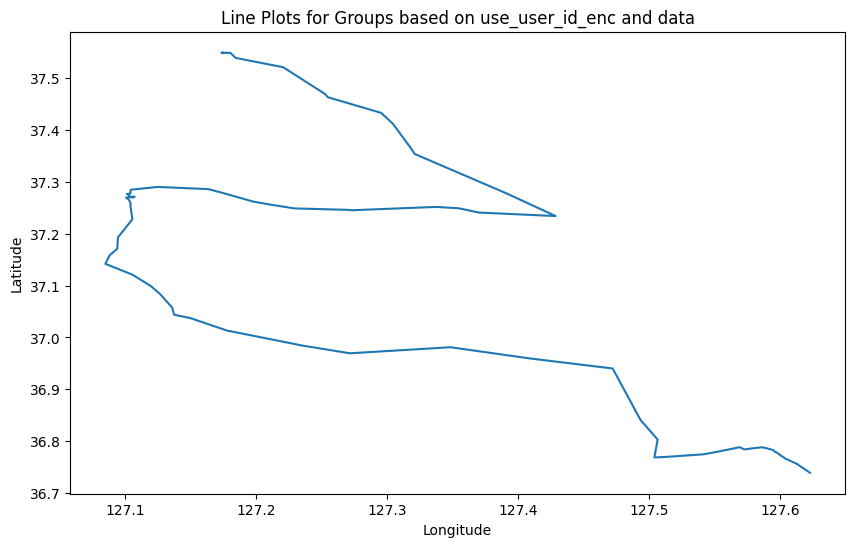

In [159]:
# 새로운 플롯 생성
plt.figure(figsize=(10, 6))

plt.plot(group['s_gps_lng'], group['s_gps_lat'], linestyle='-')


# 축 레이블 설정
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 플롯 제목 설정
plt.title('Line Plots for Groups based on use_user_id_enc and data')

# 플롯 보여주기
plt.show()

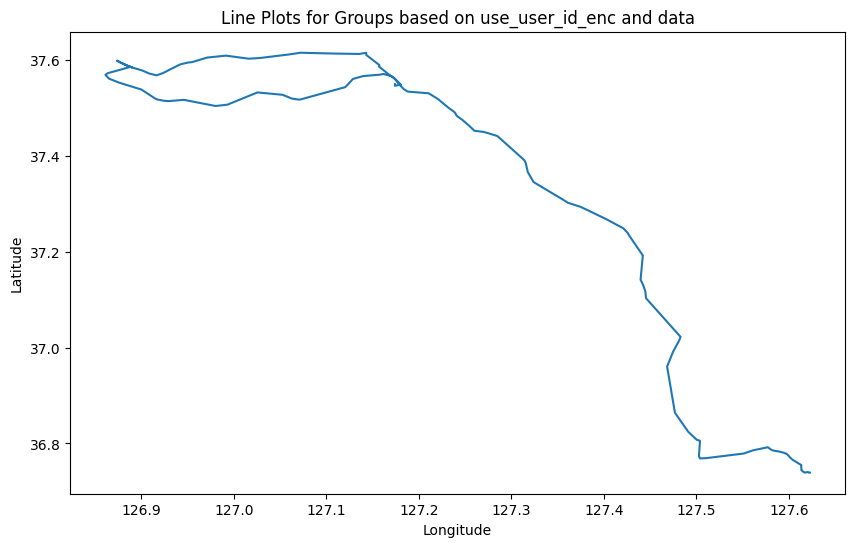

In [161]:
group = df_CET[(df_CET['use_user_id_enc'] == 'user5')&(df_CET['date'] == '2022-03-02')]
# 새로운 플롯 생성
plt.figure(figsize=(10, 6))

plt.plot(group['s_gps_lng'], group['s_gps_lat'], linestyle='-')


# 축 레이블 설정
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 플롯 제목 설정
plt.title('Line Plots for Groups based on use_user_id_enc and data')

# 플롯 보여주기
plt.show()

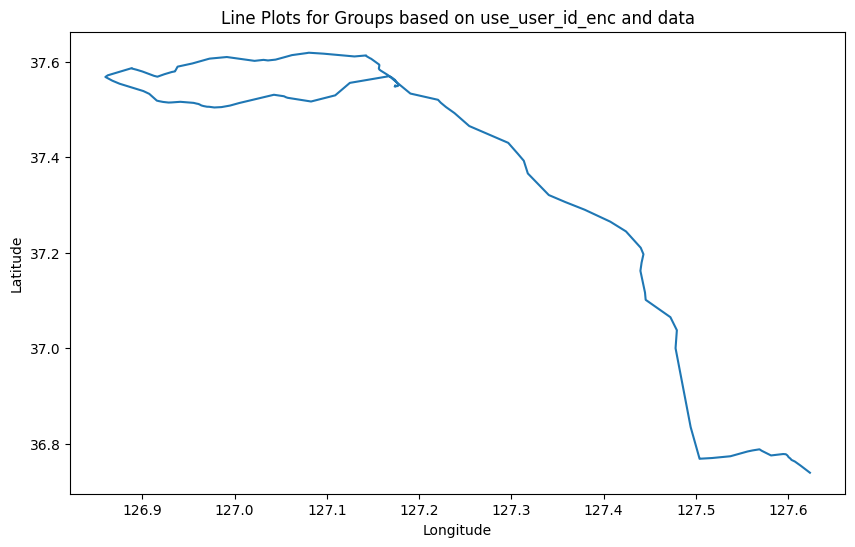

In [162]:
group = df_CET[(df_CET['use_user_id_enc'] == 'user5')&(df_CET['date'] == '2022-03-03')]
# 새로운 플롯 생성
plt.figure(figsize=(10, 6))

plt.plot(group['s_gps_lng'], group['s_gps_lat'], linestyle='-')


# 축 레이블 설정
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 플롯 제목 설정
plt.title('Line Plots for Groups based on use_user_id_enc and data')

# 플롯 보여주기
plt.show()